# Polynya overlay plots
- Plot obs and model polynya outlines
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- November 2024

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import colors as c
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load Winter satellite SIC

In [6]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [12]:
# Read in satellite polynya data
file_in = 'cdr_seaice_conc_sept_mean.noleap.1979-2022.nc'
ds_sic = xr.open_mfdataset(dir_in+file_in,decode_times=False)

sic_sat = ds_sic.cdr_seaice_conc_daily
lat_sat = ds_sic.latitude
lon_sat = ds_sic.longitude

## Load Typical polynya data

In [14]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [15]:
# Read in satellite polynya data
file_in = 'CESM_grid_SSMI_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_sat = ds_poly.polynya_typical_all

In [16]:
# Read in jra55 polynya data
file_in = 'CESM_grid_JRA55_hindcast_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_jra_hi = ds_poly.polynya_typical_all_hi
poly_jra_aice = ds_poly.polynya_typical_all_aice

In [17]:
# Read in cesm2-le polynya data
file_in = 'CESM_grid_CESM2-LE_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

# keep some decades
poly_2000_hi = ds_poly.polynya_typical_all_hi.sel(decades=2000)
poly_2000_aice = ds_poly.polynya_typical_all_aice.sel(decades=2000)

## Load map related files

### Load shapefiles

In [18]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [19]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

In [20]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [21]:
# Read in CCAMLR MPA files

# Adopted mpas
file_in = 'CCAMLR_MPAs/RossSea_no_ice_shelf/2015CCAMLR_RossSeaMore_102020.shp'
shdf_ross = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ross = shdf_ross.to_crs(ccrs.SouthPolarStereo())

# Proposed Weddell
file_in = 'CCAMLR_MPAs/WSMPA2019_Shapefile/WSMPA2019.shp'
shdf_wed = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_wed = shdf_wed.to_crs(ccrs.SouthPolarStereo())

# Proposed Weddell Phase 2
file_in = 'CCAMLR_MPAs/WSMPAP2_polygons/OuterBoundary.shp'
shdf_wed2 = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_wed2 = shdf_wed2.to_crs(ccrs.SouthPolarStereo())

# Proposed E. Antarctica
file_in = 'CCAMLR_MPAs/Earsmpa_2015_CCAMLR_XXXIV/Earsmpa_2015_CCAMLR_XXXIV.shp'
shdf_eant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_eant = shdf_eant.to_crs(ccrs.SouthPolarStereo())

# Proposed Peninsula
file_in = 'CCAMLR_MPAs/D1MPA_Vertices_2024_HS/D1MPA_Vertices_2024_HS_cut.shp'
shdf_pen = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_pen = shdf_pen.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [22]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_4/'

In [23]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [24]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

### Set plotting ranges, etc.
- All EcoIndex values go from 0 to 1

In [27]:
# set some plotting info
levels_in_poly = np.arange(0,3,1)
vmax_in = 100
vmin_in = 50
cmap_in = cmocean.cm.ice

### Plot Satellite SIC and polynyas with MPAs

In [41]:
fout = 'Fig_5_supp_satellite_sic_polynyas'

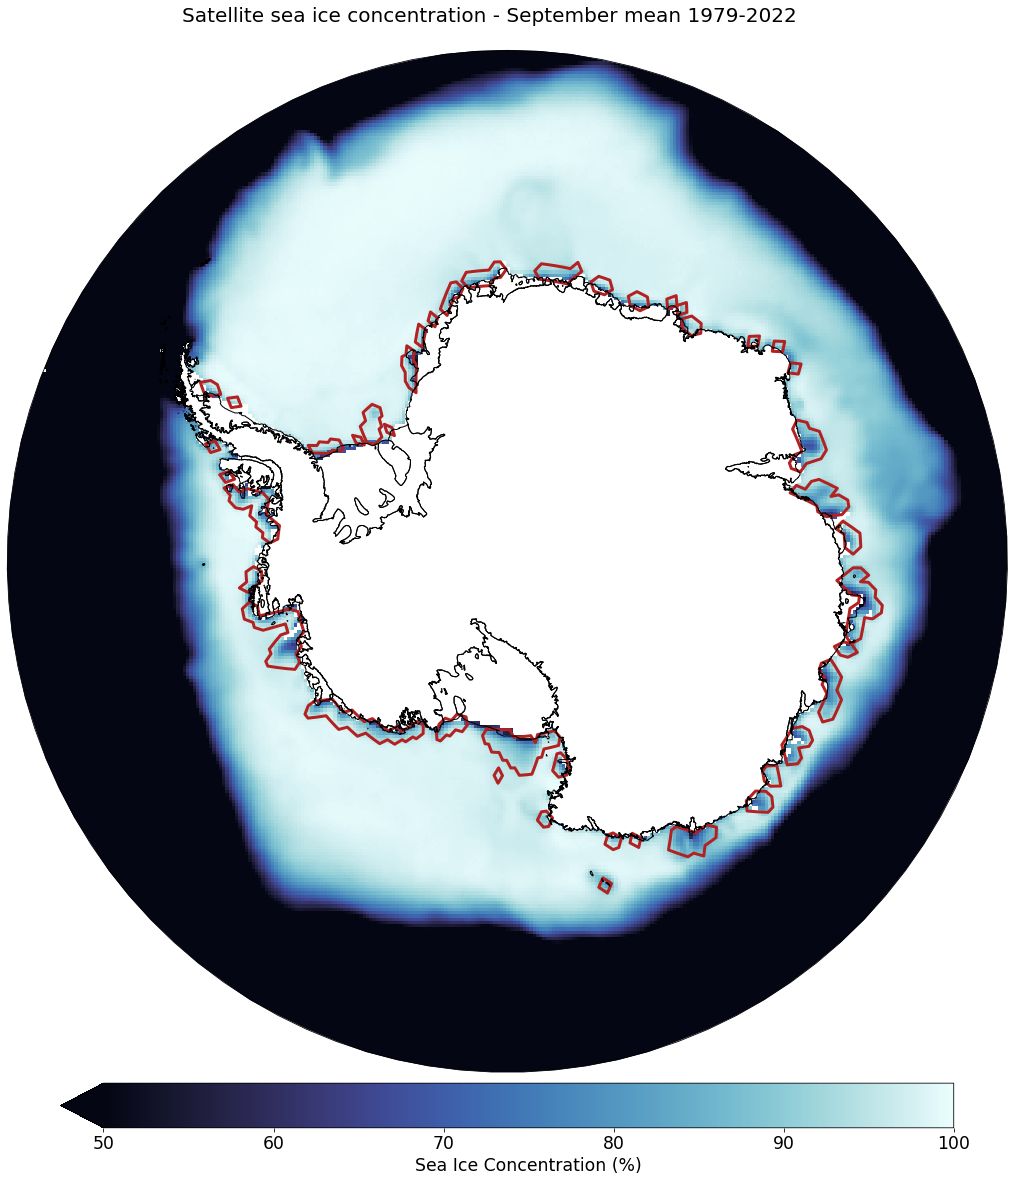

In [42]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
### plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -55], crs=ccrs.PlateCarree())

### Plot Sept. SIC
this=ax.pcolormesh(lon_sat,lat_sat,
                   sic_sat,
                   cmap=cmap_in,                      
                   vmax=vmax_in, vmin=vmin_in,
                   transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='min',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'Sea Ice Concentration (%)',fontsize='xx-large')

# Overlay polynyas - obs
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_sat.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='firebrick',linestyles='solid',linewidths=3,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 


# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
fig.suptitle('Satellite sea ice concentration - September mean 1979-2022',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'_MPAs.png', bbox_inches='tight', dpi=200)

In [43]:
fout = 'Fig_5_supp_satellite_sic_polynyas_mpa'

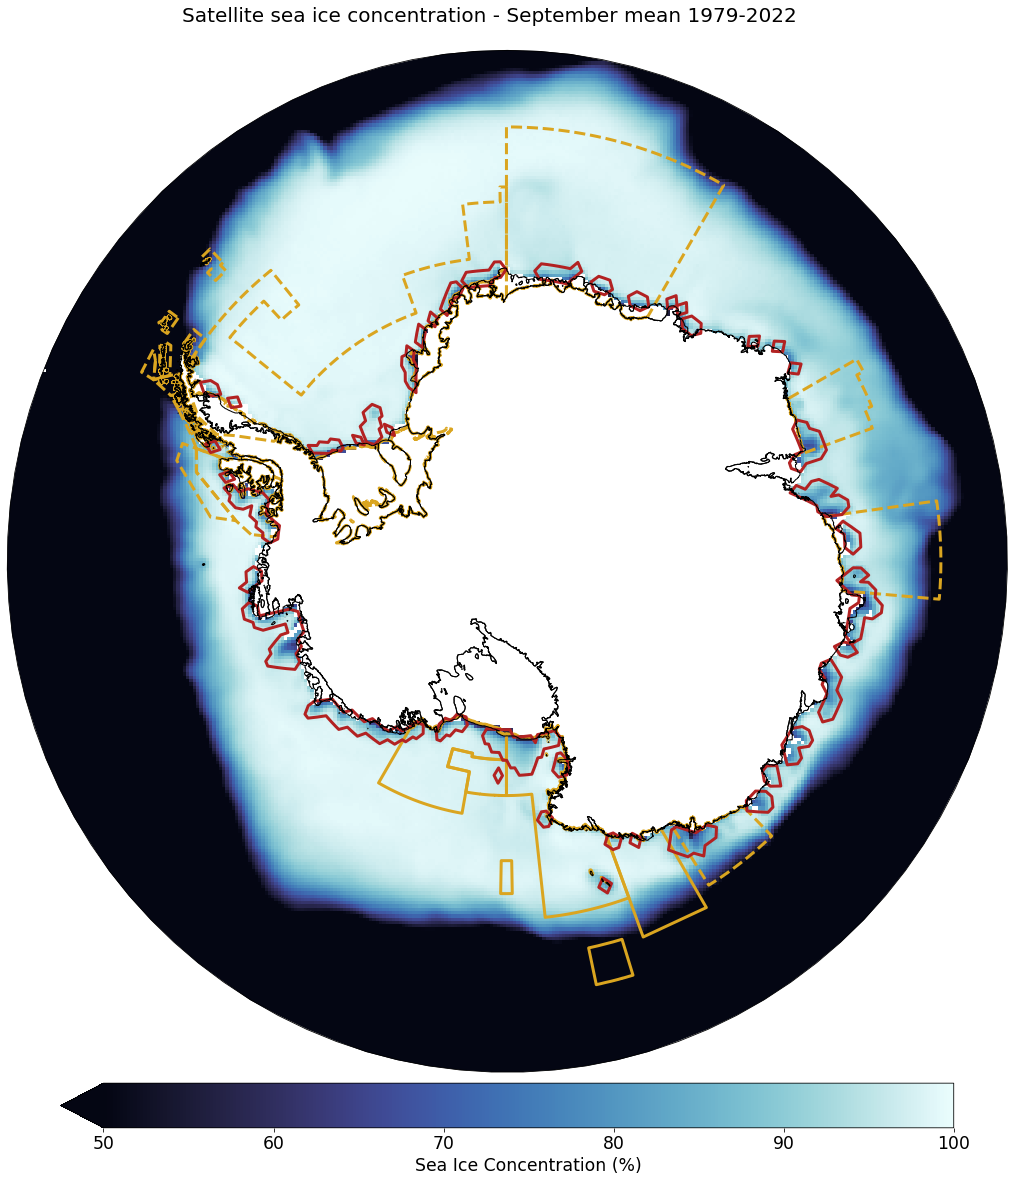

In [54]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
### plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -55], crs=ccrs.PlateCarree())

### Plot Sept. SIC
this=ax.pcolormesh(lon_sat,lat_sat,
                   sic_sat,
                   cmap=cmap_in,                      
                   vmax=vmax_in, vmin=vmin_in,
                   transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='min',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'Sea Ice Concentration (%)',fontsize='xx-large')

# Overlay polynyas - obs
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_sat.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='firebrick',linestyles='solid',linewidths=3,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 

### Add CCAMLR MPA regions
ax.add_geometries(shdf_ross.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='goldenrod',linewidth=3,linestyle='solid')
ax.add_geometries(shdf_wed.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='goldenrod',linewidth=3,linestyle='dashed')
ax.add_geometries(shdf_wed2.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='goldenrod',linewidth=3,linestyle='dashed')
ax.add_geometries(shdf_eant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='goldenrod',linewidth=3,linestyle='dashed')
ax.add_geometries(shdf_pen.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='goldenrod',linewidth=3,linestyle='dashed')


# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
fig.suptitle('Satellite sea ice concentration - September mean 1979-2022',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'_MPAs.png', bbox_inches='tight', dpi=200)

### Plot "observational" comparison

In [55]:
fout = 'Fig_5_supp_polynyas_obs'

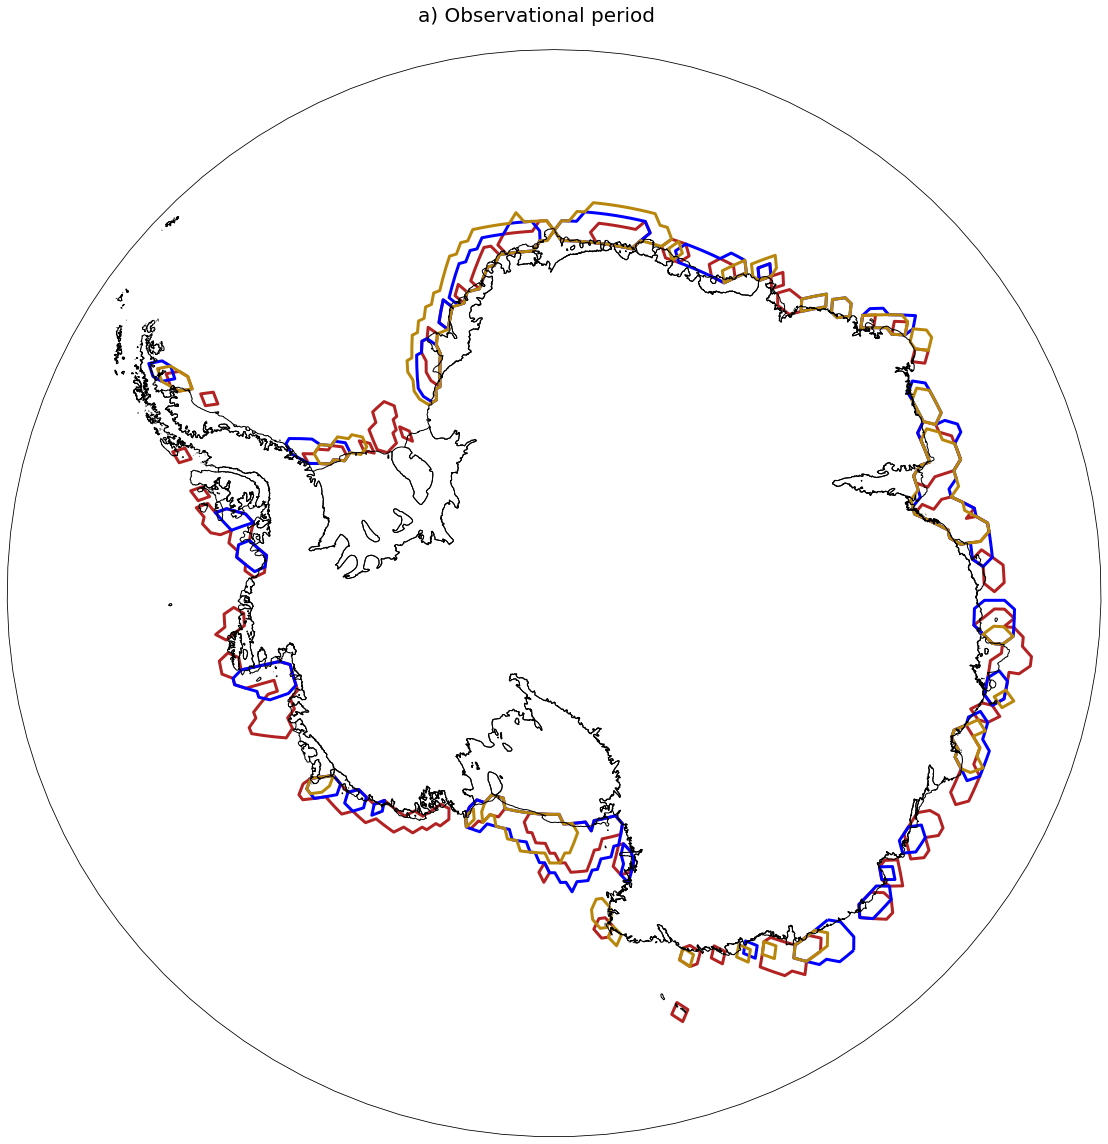

In [56]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
### plot the region as subplots - note it's nrow x ncol x index (starting upper left)
## panel 1
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

# Overlay polynyas - obs
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_sat.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='firebrick',linestyles='solid',linewidths=3,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree())
# Overlay polynyas - jra_hi
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_jra_hi.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='blue',linestyles='solid',linewidths=3,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
# Overlay polynyas - jra_aice
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_jra_aice.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='darkgoldenrod',linestyles='solid',linewidths=3,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
fig.suptitle('a) Observational period',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'_MPAs.png', bbox_inches='tight', dpi=200)

### Plot SIT threshold comparison

In [57]:
fout = 'Fig_5_supp_polynyas_hi_metric'

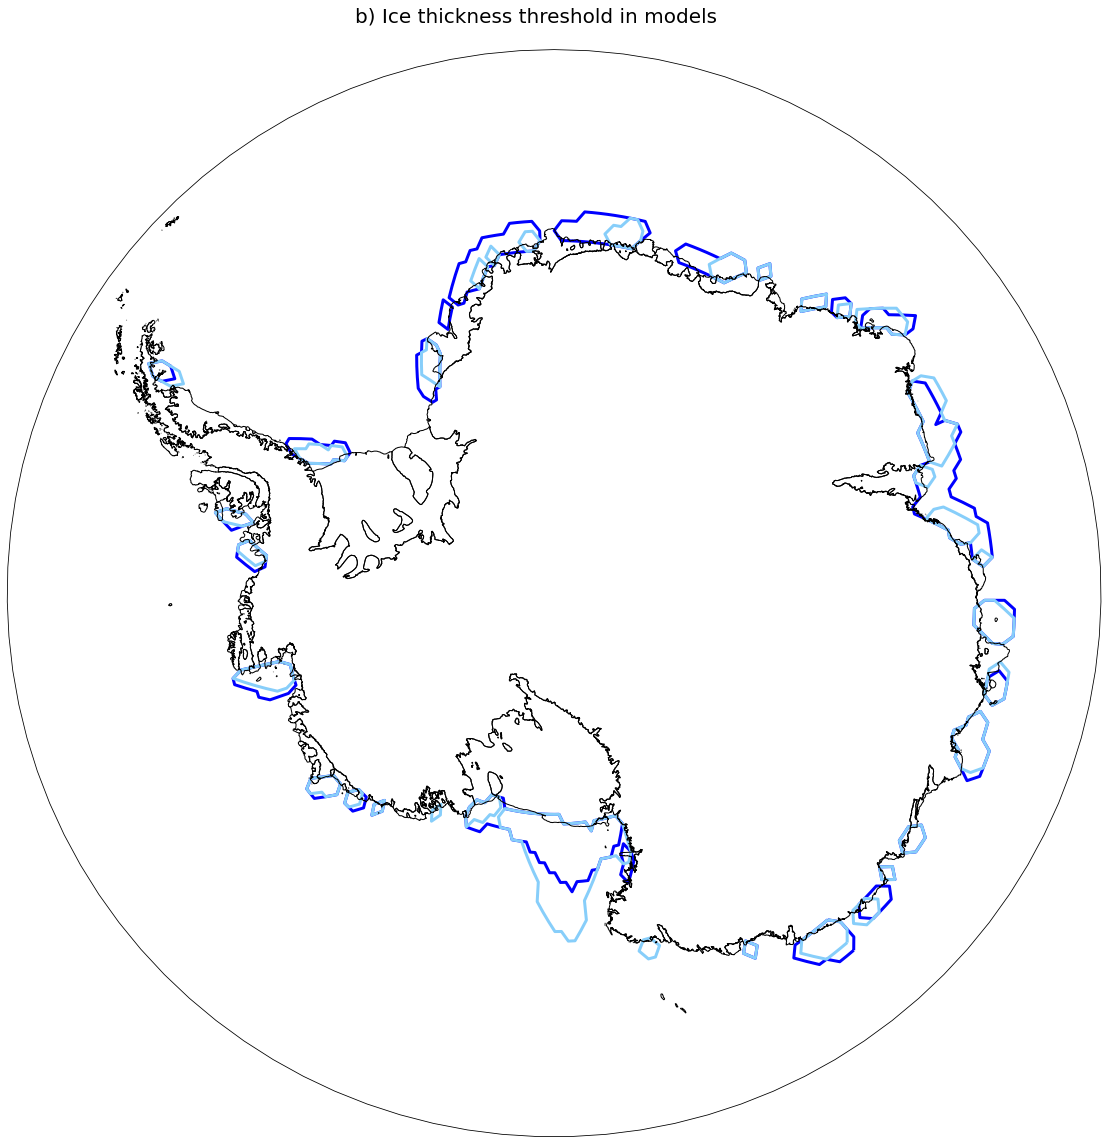

In [58]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
### plot the region as subplots - note it's nrow x ncol x index (starting upper left)
## panel 1
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

# Overlay polynyas - jra_hi
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_jra_hi.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='blue',linestyles='solid',linewidths=3,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
# Overlay polynyas - cesm2-le_hi
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2000_hi.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='lightskyblue',linestyles='solid',linewidths=3,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
fig.suptitle('b) Ice thickness threshold in models',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'_MPAs.png', bbox_inches='tight', dpi=200)

### Plot SIC threshold comparison

In [59]:
fout = 'Fig_5_supp_polynyas_aice_metric'

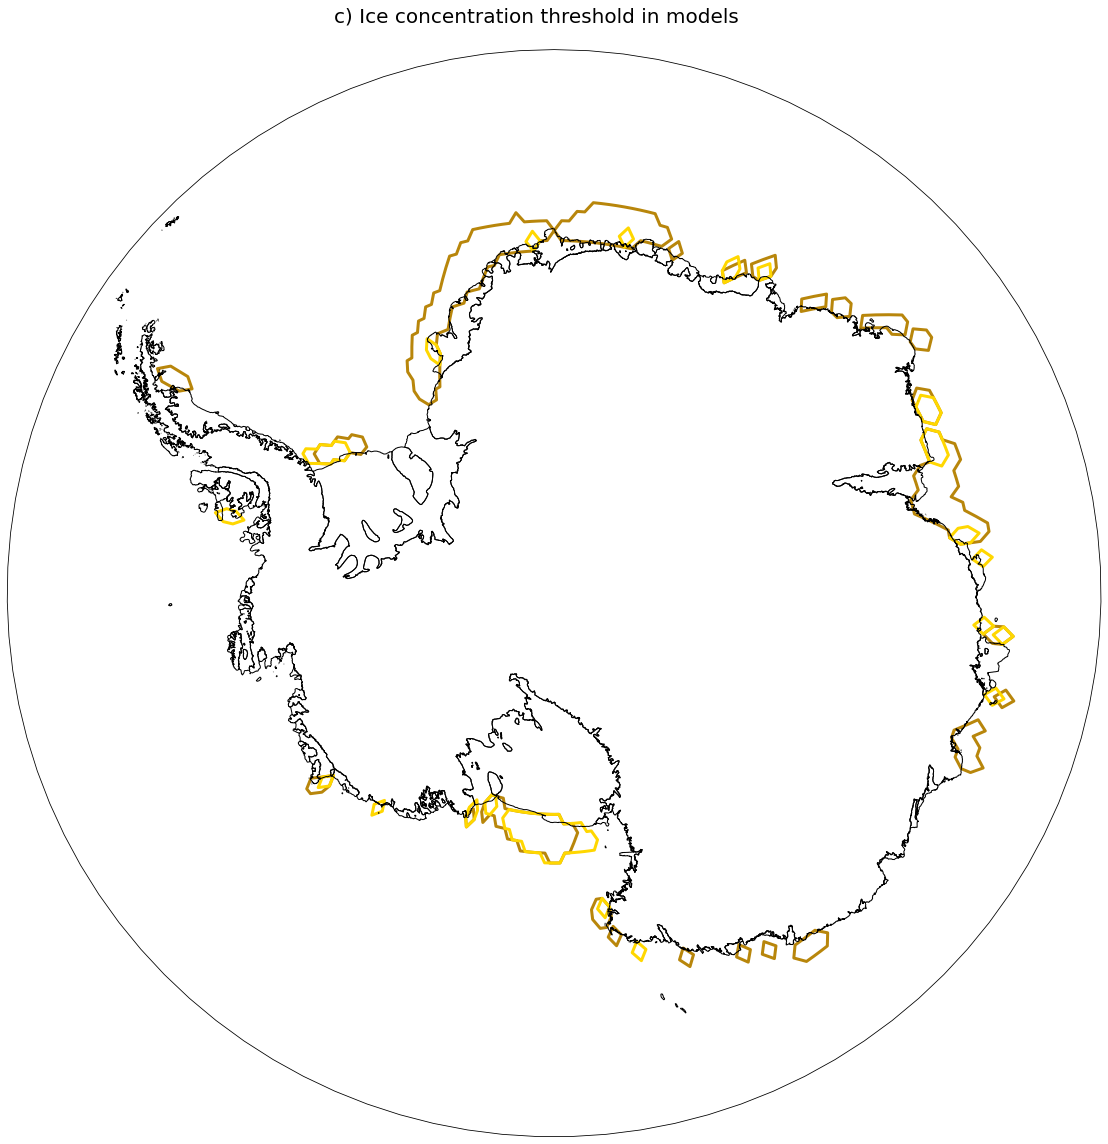

In [60]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
### plot the region as subplots - note it's nrow x ncol x index (starting upper left)
## panel 1
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

# Overlay polynyas - jra_hi
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_jra_aice.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='darkgoldenrod',linestyles='solid',linewidths=3,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
# Overlay polynyas - cesm2-le_hi
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2000_aice.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='gold',linestyles='solid',linewidths=3,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
fig.suptitle('c) Ice concentration threshold in models',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'_MPAs.png', bbox_inches='tight', dpi=200)